In [1]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.2 MB/s eta 0:00:00


In [2]:
import joblib

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, f1_score
)
from catboost import CatBoostClassifier

In [4]:
# 1. Load Data
data = pd.read_csv('adult.csv')

In [ ]:
# 2. Initial Exploration
print("\nData Shape:", data.shape)


Data Shape: (48842, 15)


In [6]:
print(data.head())

   age  workclass  fnlwgt     education  educational-num      marital-status  \
0   25    Private  226802          11th                7       Never-married   
1   38    Private   89814       HS-grad                9  Married-civ-spouse   
2   28  Local-gov  336951    Assoc-acdm               12  Married-civ-spouse   
3   44    Private  160323  Some-college               10  Married-civ-spouse   
4   18          ?  103497  Some-college               10       Never-married   

          occupation relationship   race  gender  capital-gain  capital-loss  \
0  Machine-op-inspct    Own-child  Black    Male             0             0   
1    Farming-fishing      Husband  White    Male             0             0   
2    Protective-serv      Husband  White    Male             0             0   
3  Machine-op-inspct      Husband  Black    Male          7688             0   
4                  ?    Own-child  White  Female             0             0   

   hours-per-week native-country incom

In [7]:
# Remove rows with any remaining missing values (if any)
data = data.dropna()

In [8]:
print("\nUnknown values:")
print(data.isin(['?']).sum())


Unknown values:
age                   0
workclass          2799
fnlwgt                0
education             0
educational-num       0
marital-status        0
occupation         2809
relationship          0
race                  0
gender                0
capital-gain          0
capital-loss          0
hours-per-week        0
native-country      857
income                0
dtype: int64


In [9]:
# 3. Data Cleaning
# Replace '?' with 'Unknown' in categorical columns
for col in ['workclass', 'occupation', 'native-country']:
    data[col] = data[col].replace('?', 'Unknown')

In [10]:
# Show all unique values and their counts in 'workclass' before removal
print(data['workclass'].value_counts())


workclass
Private             33906
Self-emp-not-inc     3862
Local-gov            3136
Unknown              2799
State-gov            1981
Self-emp-inc         1695
Federal-gov          1432
Without-pay            21
Never-worked           10
Name: count, dtype: int64


In [11]:
# Remove irrelevant workclass values
for val in ['Without-pay', 'Never-worked']:
    data = data[data['workclass'] != val]

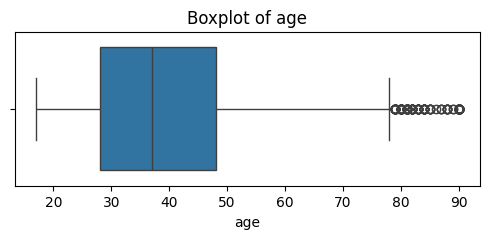

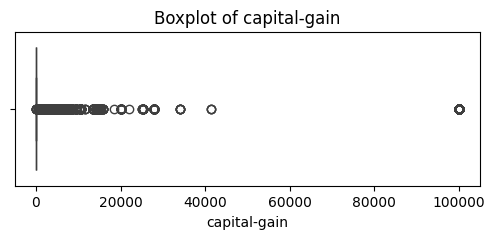

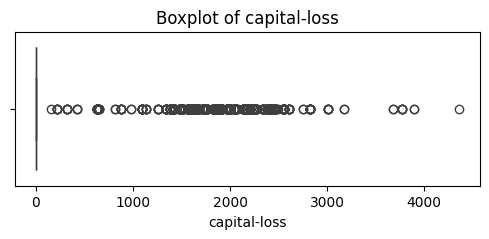

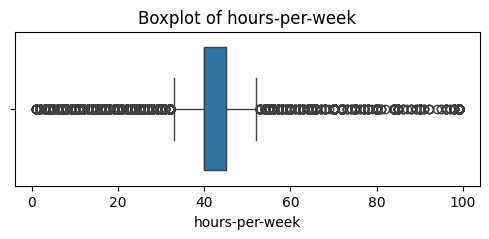

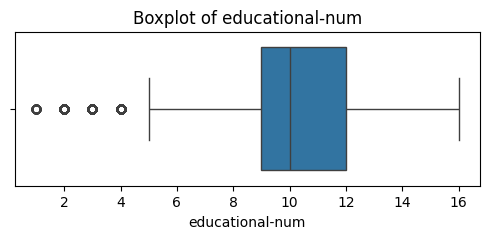

In [12]:

# 4. Outlier Detection & Removal (with plots)
outlier_cols = ['age', 'capital-gain', 'capital-loss', 'hours-per-week', 'educational-num']
for col in outlier_cols:
    plt.figure(figsize=(6,2))
    sns.boxplot(x=data[col])
    plt.title(f'Boxplot of {col}')
    plt.show()
    # Remove outliers using 1st and 99th percentiles
    q_low = data[col].quantile(0.01)
    q_high = data[col].quantile(0.99)
    data = data[(data[col] >= q_low) & (data[col] <= q_high)]


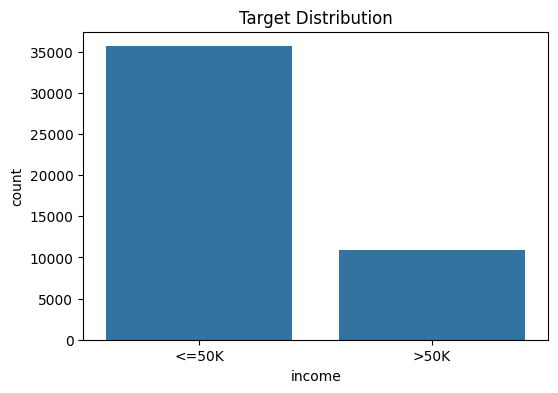

In [13]:
# 5. EDA (Distributions, Correlations, Target Balance)
plt.figure(figsize=(6,4))
sns.countplot(x='income', data=data)
plt.title('Target Distribution')
plt.show()

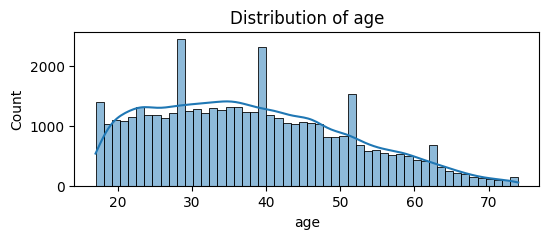

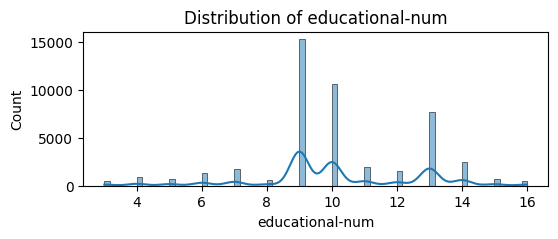

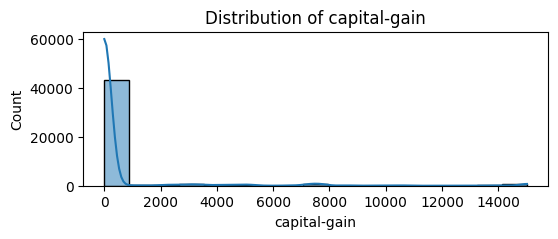

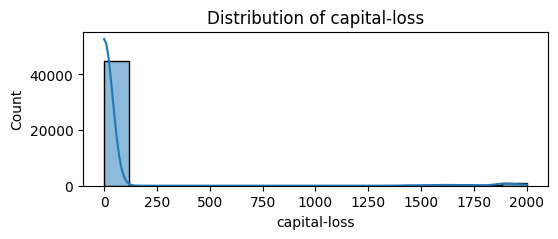

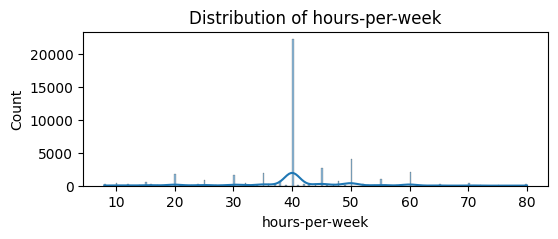

In [14]:
# Plot distributions for numerical features
num_cols = ['age', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']
for col in num_cols:
    plt.figure(figsize=(6,2))
    sns.histplot(data[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

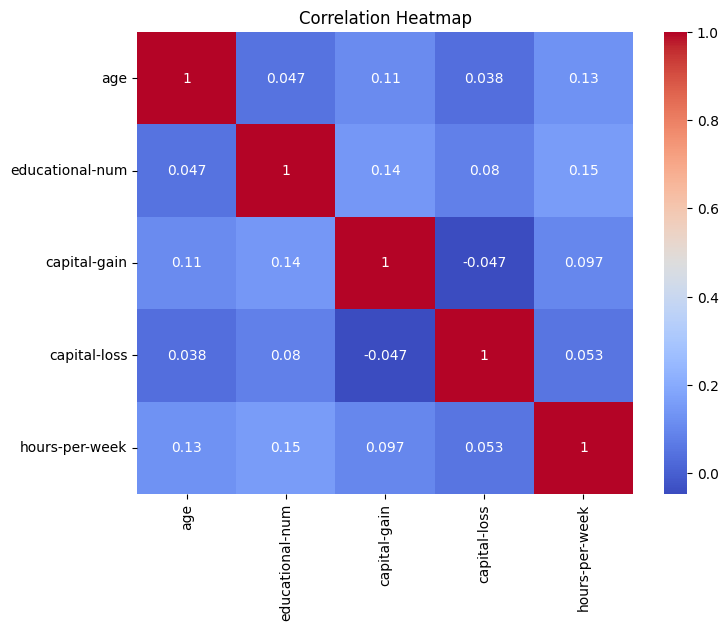

In [15]:
# Correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(data[num_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [16]:
# Drop redundant 'education' column (both education and educational-num represent same thing)
if 'education' in data.columns:
    data = data.drop(columns=['education'])

In [17]:
# 7. Prepare Features and Target
categorical_features = [
    'workclass', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country'
]
numerical_features = [
    'age', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week',
]
X = data[categorical_features + numerical_features]
y = data['income'].apply(lambda x: 1 if x.strip() == '>50K' else 0)


In [18]:
# 8. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [19]:
# 9. CatBoost: Categorical Feature Indices
cat_features_idx = [X.columns.get_loc(col) for col in categorical_features]


In [20]:
# 10. Model Training
model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    eval_metric='Accuracy',
    cat_features=cat_features_idx,
    verbose=100,
    random_state=42
)
model.fit(X_train, y_train, eval_set=(X_test, y_test), cat_features=cat_features_idx, verbose=100)


0:	learn: 0.8497408	test: 0.8485174	best: 0.8485174 (0)	total: 215ms	remaining: 1m 47s
100:	learn: 0.8735126	test: 0.8678556	best: 0.8680705 (93)	total: 15.9s	remaining: 1m 2s
200:	learn: 0.8789922	test: 0.8697894	best: 0.8703266 (154)	total: 23.4s	remaining: 34.8s
300:	learn: 0.8815708	test: 0.8702192	best: 0.8709712 (259)	total: 29.7s	remaining: 19.6s
400:	learn: 0.8845255	test: 0.8706489	best: 0.8712935 (379)	total: 37.2s	remaining: 9.18s
499:	learn: 0.8875071	test: 0.8714009	best: 0.8717232 (422)	total: 43.5s	remaining: 0us

bestTest = 0.8717232488
bestIteration = 422

Shrink model to first 423 iterations.


In [21]:
# 11. Model Evaluation
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]



In [22]:
print("\nCatBoost Accuracy:", accuracy_score(y_test, y_pred))



CatBoost Accuracy: 0.8717232488182208


In [23]:
print("\nClassification Report:\n", classification_report(y_test, y_pred))



Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.94      0.92      7127
           1       0.77      0.65      0.70      2181

    accuracy                           0.87      9308
   macro avg       0.83      0.79      0.81      9308
weighted avg       0.87      0.87      0.87      9308



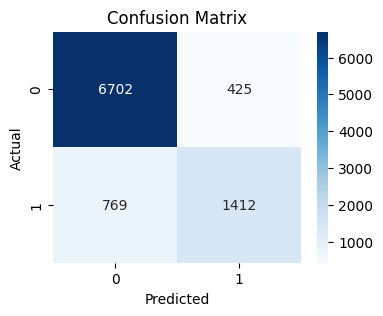

In [24]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

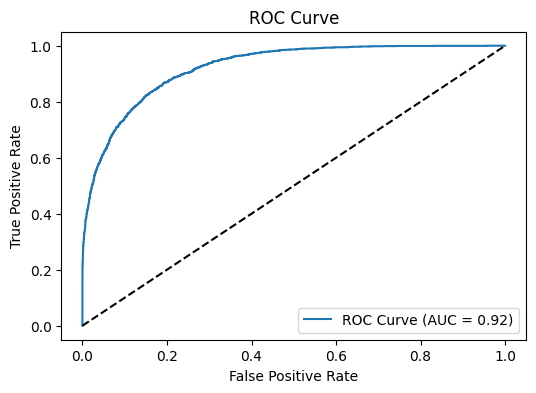

In [25]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_proba):.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

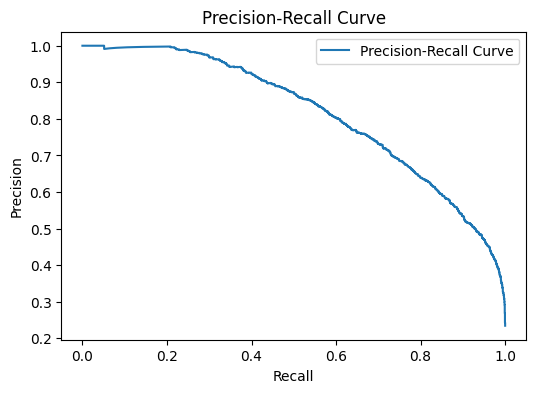

In [26]:
# Precision-Recall Curve
prec, rec, pr_thresh = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(rec, prec, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [27]:
# 12. Threshold Tuning
print("\nThreshold tuning:")
best_f1 = 0
best_thresh = 0.5
for thresh in [0.3, 0.4, 0.5, 0.6, 0.7]:
    y_pred_thresh = (y_proba > thresh).astype(int)
    f1 = f1_score(y_test, y_pred_thresh)
    acc = accuracy_score(y_test, y_pred_thresh)
    print(f"Threshold: {thresh}, F1: {f1:.4f}, Accuracy: {acc:.4f}")
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = thresh
print(f"\nBest threshold by F1: {best_thresh} (F1={best_f1:.4f})")



Threshold tuning:
Threshold: 0.3, F1: 0.7112, Accuracy: 0.8454
Threshold: 0.4, F1: 0.7183, Accuracy: 0.8664
Threshold: 0.5, F1: 0.7028, Accuracy: 0.8717
Threshold: 0.6, F1: 0.6732, Accuracy: 0.8713
Threshold: 0.7, F1: 0.6071, Accuracy: 0.8602

Best threshold by F1: 0.4 (F1=0.7183)


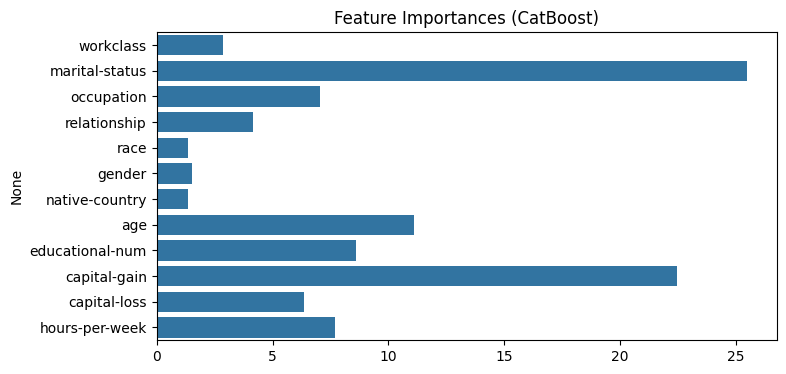

In [28]:
# 13. Feature Importance
feat_imp = model.get_feature_importance()
plt.figure(figsize=(8,4))
sns.barplot(x=feat_imp, y=X.columns)
plt.title('Feature Importances (CatBoost)')
plt.show()


In [29]:

# 14. Summary
print("\nSummary:")
print(f"Best CatBoost Test Accuracy: {max([accuracy_score(y_test, (y_proba > t).astype(int)) for t in [0.3,0.4,0.5,0.6,0.7]]):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")
print(f"Best F1: {best_f1:.4f} at threshold {best_thresh}")
print("\nProject pipeline complete. All steps from EDA to evaluation and reporting are included.")


Summary:
Best CatBoost Test Accuracy: 0.8717
ROC AUC: 0.9229
Best F1: 0.7183 at threshold 0.4

Project pipeline complete. All steps from EDA to evaluation and reporting are included.


In [30]:
# 15. Save the final model and column order
model_filename = 'catboost_salary_model.joblib'
columns_filename = 'model_columns.joblib'

# Save the trained model
joblib.dump(model, model_filename)

# Save the column order used for training
joblib.dump(X.columns.tolist(), columns_filename)

print(f"\nModel saved as {model_filename}")
print(f"Model columns saved as {columns_filename}")

from google.colab import files
files.download(model_filename)
files.download(columns_filename)


Model saved as catboost_salary_model.joblib
Model columns saved as model_columns.joblib


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>